# NFL 2020 Forecasting Yards Gained

> “The running back takes the handoff… he breaks a tackle…spins… and breaks free! One man to beat! Past the 50-yard-line! To the 40! The 30! He! Could! Go! All! The! Way!”

But will he?

American football is a complex sport. From the 22 players on the field to specific characteristics that ebb and flow throughout the game, it can be challenging to quantify the value of specific plays and actions within a play. Fundamentally, the goal of football is for the offense to run (rush) or throw (pass) the ball to gain yards, moving towards, then across, the opposing team’s side of the field in order to score. And the goal of the defense is to prevent the offensive team from scoring.

In the National Football League (NFL), roughly a third of teams’ offensive yardage comes from run plays.. Ball carriers are generally assigned the most credit for these plays, but their teammates (by way of blocking), coach (by way of play call), and the opposing defense also play a critical role. Traditional metrics such as ‘yards per carry’ or ‘total rushing yards’ can be flawed; in this competition, the NFL aims to provide better context into what contributes to a successful run play.

As an “armchair quarterback” watching the game, you may think you can predict the result of a play when a ball carrier takes the handoff - but what does the data say? Deeper insight into rushing plays will help teams, media, and fans better understand the skill of players and the strategies of coaches. It will also assist the NFL and its teams evaluate the ball carrier, his teammates, his coach, and the opposing defense, in order to make adjustments as necessary.

## Data Cleaning

**Import Packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from string import punctuation

**Read Data**

In [2]:
nfl = pd.read_csv('Data/train.csv')
nfl.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [3]:
nfl.shape

(509762, 49)

In [4]:
nfl.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')

In [3]:
nfl.rename(columns={'X': 'long_axis', 'Y': 'short_axis',
                   'S': 'speed', 'A': 'accel'}, inplace=True)

In [4]:
nfl_id = nfl[['GameId', 'PlayId', 'Team', 'NflId',
              'DisplayName', 'JerseyNumber', 'NflIdRusher',
              'PlayerCollegeName', 'HomeTeamAbbr',
              'VisitorTeamAbbr', 'PlayerBirthDate',
              'Stadium', 'Location']]

nfl = nfl.drop(['GameId', 'PlayId', 'NflId', 'Location',
                'JerseyNumber', 'NflIdRusher',
                'PlayerBirthDate', 'PlayerCollegeName',
                'TimeHandoff', 'TimeSnap', 'Stadium'],
               axis=1)

Index(['Team', 'long_axis', 'short_axis', 'speed', 'accel', 'Dis',
       'Orientation', 'Dir', 'DisplayName', 'Season', 'YardLine', 'Quarter',
       'GameClock', 'PossessionTeam', 'Down', 'Distance', 'FieldPosition',
       'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'OffenseFormation',
       'OffensePersonnel', 'DefendersInTheBox', 'DefensePersonnel',
       'PlayDirection', 'Yards', 'PlayerHeight', 'PlayerWeight', 'Position',
       'HomeTeamAbbr', 'VisitorTeamAbbr', 'Week', 'StadiumType', 'Turf',
       'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')

```
cities = {'Orchard Park NY': 'Orchard Park, NY',
          'Chicago. IL': 'Chicago, IL',
          'Houston, Texas': 'Houston, TX',
          'Los Angeles, Calif.': 'Los Angeles, CA',
          'Arlington, Texas': 'Arlington, TX',
          'Baltimore, Md.': 'Baltimore, MD',
          'Charlotte, North Carolina': 'Charlotte, NC',
          'Indianapolis, Ind.': 'Indianapolis, IN',
          'Cincinnati, Ohio': 'Cincinnati, OH',
          'Pittsburgh': 'Pittsburgh, PA',
          'Detroit': 'Detroit, MI',
          'Foxborough, Ma': 'Foxborough, MA',
          'Miami Gardens, Fla.': 'Miami Gardens, FL',
          'Philadelphia, Pa.': 'Philadelphia, PA',
          'London': 'London, England',
          'New Orleans, La.': 'New Orleans, LA',
          'Mexico City': 'Mexico City, Mexico',
          'Baltimore, Maryland': 'Baltimore, MD',
          'Jacksonville, Fl': 'Jacksonville, FL',
          'Jacksonville, Florida': 'Jacksonville, FL',
          'Cleveland,Ohio': 'Cleveland, OH',
          'East Rutherford, N.J.': 'East Rutherford, NJ',
          'E. Rutherford, NJ': 'East Rutherford, NJ',
          'Seattle': 'Seattle, WA',
          'Cleveland Ohio': 'Cleveland, OH',
          'Miami Gardens, FLA': 'Miami Gardens, FL',
          'Cleveland': 'Cleveland, OH',
          'Kansas City,  MO': 'Kansas City, MO',
          'Jacksonville Florida': 'Jacksonville, FL',
          'New Orleans': 'New Orleans, LA',
          'Cleveland, Ohio': 'Cleveland, OH'}
```

In [5]:
null_cols = []
for col in nfl.columns:
    if nfl[col].isna().any() == True:
        null_cols.append(col)
        
for col in null_cols:
    if nfl[col].dtype == 'O':
        nfl[col].fillna(nfl[col].value_counts().index[0],
                       inplace=True)
    else:
        nfl[col].fillna(nfl[col].median(), inplace=True)

In [6]:
# set stadium type as outdoor or indoor
stadium_types = {'Outdoor': 'Outdoor',
                 'Indoor': 'Indoor',
                 'Outdoors': 'Outdoor',
                 'Indoors': 'Indoor',
                 'Dome': 'Indoor',
                 'Retractable Roof': 'Indoor',
                 'Open': 'Outdoor',
                 'Retr. Roof-Closed': 'Indoor',
                 'Retr. Roof - Closed': 'Indoor',
                 'Domed, closed': 'Indoor',
                 'Domed, open': 'Outdoor',
                 'Closed Dome': 'Indoor',
                 'Domed': 'Indoor',
                 'Dome, closed': 'Indoor',
                 'Oudoor': 'Outdoor',
                 'Retr. Roof Closed': 'Indoor',
                 'Indoor, Roof Closed': 'Indoor',
                 'Retr. Roof-Open': 'Outdoor',
                 'Bowl': 'Outdoor',
                 'Outddors': 'Outdoor',
                 'Heinz Field': 'Outdoor',
                 'Retr. Roof - Open': 'Outdoor',
                 'Outdoor Retr Roof-Open': 'Outdoor',
                 'Outdor': 'Outdoor',
                 'Ourdoor': 'Outdoor',
                 'Indoor, Open Roof': 'Outdoor',
                 'Outside': 'Outdoor',
                 'Cloudy': 'Outdoor',
                 'Domed, Open': 'Outdoor'}

nfl['StadiumType'] = nfl['StadiumType'].apply(lambda x: stadium_types[x])

In [7]:
grass = {'Grass': 'Natural',
         'Natural Grass': 'Natural',
         'Field Turf': 'Artificial',
         'Artificial': 'Artificial',
         'FieldTurf': 'Artificial',
         'UBU Speed Series-S5-M': 'Artificial',
         'A-Turf Titan': 'Artificial',
         'UBU Sports Speed S5-M': 'Artificial',
         'FieldTurf360': 'Artificial',
         'DD GrassMaster': 'Mix',
         'Twenty-Four/Seven Turf': 'Artificial',
         'SISGrass': 'Mix',
         'FieldTurf 360': 'Artificial',
         'Natural grass': 'Natural',
         'Artifical': 'Artificial',
         'Natural': 'Natural',
         'Field turf': 'Artificial',
         'Naturall Grass': 'Natural',
         'grass': 'Natural',
         'natural grass': 'Natural'}

nfl['Turf'] = nfl['Turf'].apply(lambda x: grass[x])

In [8]:
weather = {'Controlled Climate': 'Indoor',
          'N/A (Indoors)': 'Indoor',
          'Indoors': 'Indoor',
          'N/A Indoor': 'Indoor',
          'Sunny, highs to upper 80s': 'Sunny',
          'Cloudy, fog started developing in 2nd quarter': 'Cloudy, fog',
          'Rain likely, temps in low 40s.': 'Rain',
          'Cloudy, 50% change of rain': 'Cloudy',
          'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.': 'Cloudy, rain',
          'Cloudy, chance of rain': 'Cloudy, rain',
          'Cloudy, light snow accumulating 1-3"': 'Cloudy, snow',
          'Rain Chance 40%': 'Rain',
          'Rainy': 'Rain',
          'Partly sunny': 'Partly Sunny',
          'Partly cloudy': 'Partly Cloudy',
          'Clear skies': 'Clear Skies',
          'cloudy': 'Cloudy',
          'Heavy lake effect snow': 'Snow',
          'Cloudy and Cool': 'Cloudy and cool',
          'Partly Clouidy': 'Partly Cloudy',
          'Cloudy, Rain': 'Cloudy, rain',
          'Clear and Cool': 'Clear and cool',
          'Clear and Sunny': 'Clear and sunny',
          'Mostly cloudy': 'Mostly Cloudy',
          'Mostly sunny': 'Mostly Sunny',
          '30% Chance of Rain': 'Rain',
          'Partly Cloudly': 'Partly Cloudy',
          'Coudy': 'Cloudy',
          'Mostly coudy': 'Mostly Cloudy',
          'Partly clear': 'Partly Clear',
          'T: 51; H: 55; W: NW 10 mph': 'Fair',
          'Party Cloudy': 'Partly Cloudy',
          'Mostly Coudy': 'Mostly Cloudy'}

nfl['GameWeather'] = nfl['GameWeather'].apply(lambda x: weather[x]
                                              if x in weather.keys()
                                             else x)

In [9]:
pos = {'OLB': 'LB',
       'ILB': 'LB',
       'MLB': 'LB',
       'SS': 'S',
       'FS': 'S',
       'SAF': 'S',
       'T': 'OT'}

nfl['Position'] = nfl['Position'].apply(lambda x: pos[x]
                                        if x in pos.keys()
                                        else x)

In [11]:
def give_me_WindSpeed(x):
    x = str(x)
    x = x.replace('mph', '').strip()
    if '-' in x:
        x = (int(x.split('-')[0]) + int(x.split('-')[1])) / 2
    try:
        return float(x)
    except:
        return -99


nfl['WindSpeed'] = nfl['WindSpeed'].apply(lambda p: give_me_WindSpeed(p))

In [12]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans


nfl['GameClock'] = nfl['GameClock'].apply(strtoseconds)

In [39]:
nfl['TeamAbbr'] = nfl.apply(lambda row: row['HomeTeamAbbr']
                            if row['Team'] == 'home'
                            else row['VisitorTeamAbbr'], axis=1)
nfl['OppTeamAbbr'] = nfl.apply(lambda row: row['VisitorTeamAbbr']
                               if row['Team'] == 'home'
                               else row['HomeTeamAbbr'], axis=1)
nfl.drop(['HomeTeamAbbr', 'VisitorTeamAbbr'], axis=1, inplace=True)

,Team,long_axis,short_axis,speed,accel,Dis,Orientation,Dir,DisplayName,Season,...,Week,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,TeamAbbr,OppTeamAbbr
0,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,Eric Berry,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
1,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,Allen Bailey,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
2,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,Justin Houston,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
3,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,Derrick Johnson,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
4,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,Ron Parker,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
5,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,Dee Ford,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
6,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,Terrance Mitchell,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
7,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,Phillip Gaines,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
8,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,Daniel Sorensen,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
9,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,Marcus Peters,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE


In [13]:
diff_abbr = []
for x, y in zip(sorted(nfl['TeamAbbr'].unique()),
                sorted(nfl['PossessionTeam'].unique())):
    if x != y:
        print(x + " " + y)

ARI ARZ
BAL BLT
CLE CLV
HOU HST


In [14]:
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in nfl['PossessionTeam'].unique():
    map_abbr[abb] = abb

nfl['PossessionTeam'] = nfl['PossessionTeam'].map(map_abbr)
nfl['TeamAbbr'] = nfl['TeamAbbr'].map(map_abbr)
nfl['OppTeamAbbr'] = nfl['OppTeamAbbr'].map(map_abbr)

In [15]:
nfl['PlayerHeight'] = nfl['PlayerHeight'].apply(lambda x:
                                                12*int(x.split('-')[0])
                                                + int(x.split('-')[1]))

In [16]:
def clean_WindDirection(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = txt.replace('from', '')
    txt = txt.replace(' ', '')
    txt = txt.replace('north', 'n')
    txt = txt.replace('south', 's')
    txt = txt.replace('west', 'w')
    txt = txt.replace('east', 'e')
    txt = txt.replace('13', 'wnw')
    txt = txt.replace('1', 'nne')
    txt = txt.replace('8', 's')
    txt = txt.replace('calm', 'ne') # most common value
    return txt


nfl['WindDirection'] = nfl['WindDirection'].apply(clean_WindDirection)

In [17]:
nfl['long_axis'] = nfl.apply(lambda row: row['long_axis']
                     if row['PlayDirection']
                     else 120-row['long_axis'], axis=1)

def new_orientation(angle, play_direction):
    if play_direction == 0:
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle
    
nfl['Orientation'] = nfl.apply(lambda row: new_orientation(row['Orientation'],
                                                           row['PlayDirection']),
                               axis=1)
nfl['Dir'] = nfl.apply(lambda row: new_orientation(row['Dir'],
                                                   row['PlayDirection']),
                       axis=1)

## Exploratory Data Analysis (EDA)

In [41]:
nfl

,Team,long_axis,short_axis,speed,accel,Dis,Orientation,Dir,DisplayName,Season,...,Week,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,TeamAbbr,OppTeamAbbr
0,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,Eric Berry,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
1,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,Allen Bailey,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
2,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,Justin Houston,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
3,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,Derrick Johnson,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
4,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,Ron Parker,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
5,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,Dee Ford,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
6,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,Terrance Mitchell,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
7,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,Phillip Gaines,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
8,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,Daniel Sorensen,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE
9,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,Marcus Peters,2017,...,1,Outdoor,Artificial,Clear and warm,63.0,77.0,8.0,sw,KC,NE


In [102]:
for col in nfl.columns:
    if nfl[col].dtype == 'O':
        print(col)

Team
DisplayName
PossessionTeam
FieldPosition
OffenseFormation
OffensePersonnel
DefensePersonnel
PlayDirection
Position
StadiumType
Turf
GameWeather
WindDirection
TeamAbbr
OppTeamAbbr


In [109]:
nfl['OffenseFormation'].value_counts()

SINGLEBACK    225544
SHOTGUN       150964
I_FORM        106062
PISTOL         13420
JUMBO          11462
WILDCAT         1782
EMPTY            506
ACE               22
Name: OffenseFormation, dtype: int64

In [103]:
nfl['FieldPosition'].value_counts()

BUF    23892
OAK    17182
NYG    17160
ARZ    17072
MIA    16984
NYJ    16896
CLV    16676
CIN    16588
DEN    16566
SF     16456
SEA    16412
HST    16346
CHI    16060
IND    16038
TEN    15972
GB     15862
LA     15818
JAX    15620
DAL    15576
WAS    15554
DET    15444
BLT    15356
TB     15246
MIN    15158
LAC    15114
ATL    14938
KC     14784
NE     14718
PIT    14366
PHI    13442
NO     13332
CAR    13134
Name: FieldPosition, dtype: int64

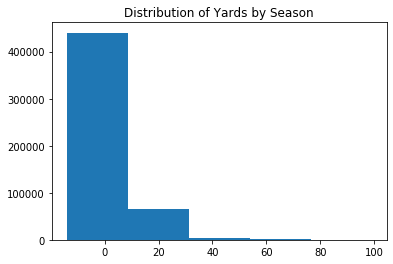

In [81]:
plt.hist(nfl.Yards, bins=5)
plt.title('Distribution of Yards by Season');

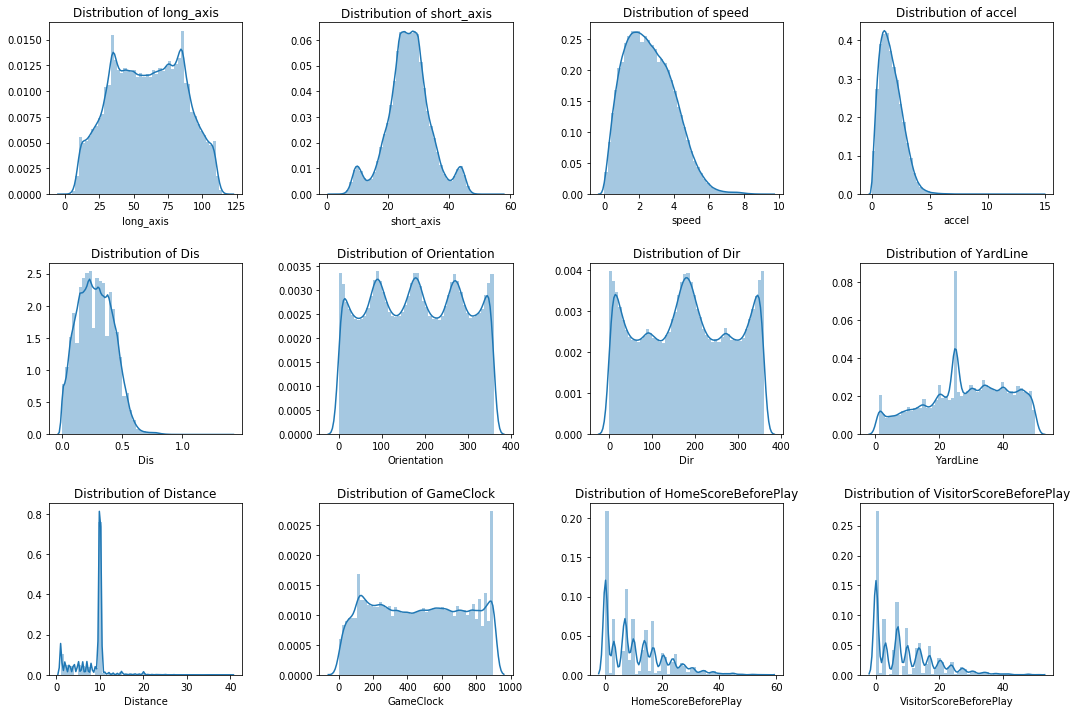

In [77]:
numeric_feats = ['long_axis', 'short_axis', 'speed', 'accel',
                 'Dis', 'Orientation', 'Dir', 'YardLine', 'Distance',
                 'GameClock', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay']

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i, feat in enumerate(numeric_feats):
    sns.distplot(nfl[feat], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'Distribution of {feat}');

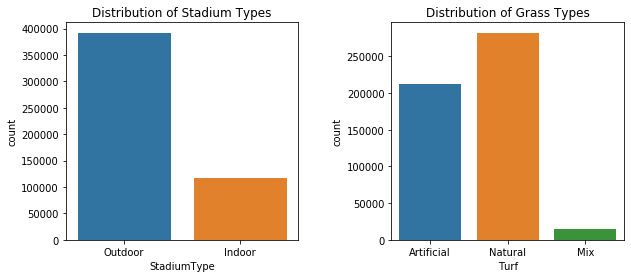

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.4)
sns.countplot(nfl.StadiumType, ax=axes[0])
sns.countplot(nfl.Turf, ax=axes[1])
axes[0].set_title('Distribution of Stadium Types')
axes[1].set_title('Distribution of Grass Types');

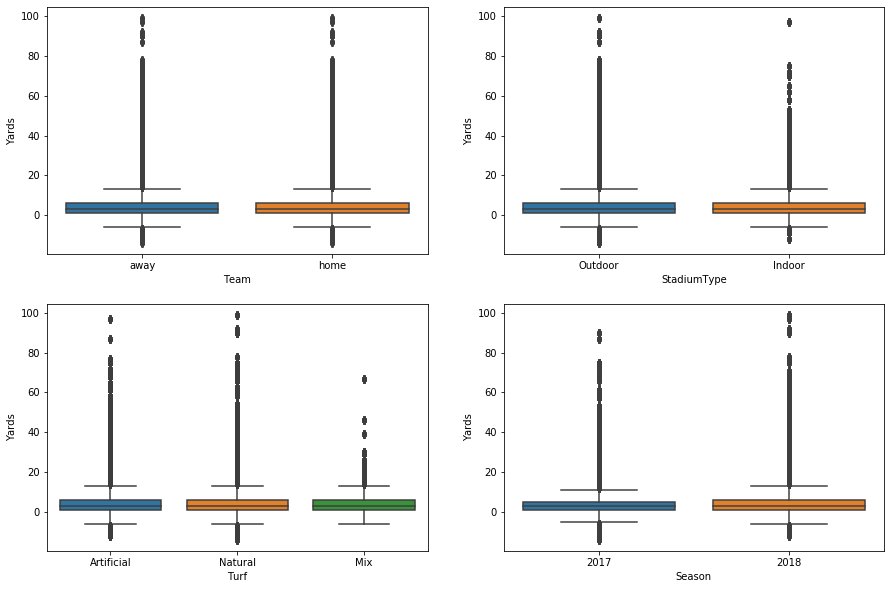

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(nfl.Team, nfl.Yards, ax=axes[0, 0])
sns.boxplot(nfl.StadiumType, nfl.Yards, ax=axes[0, 1])
sns.boxplot(nfl.Turf, nfl.Yards, ax=axes[1, 0])
sns.boxplot(nfl.Season, nfl.Yards, ax=axes[1, 1]);

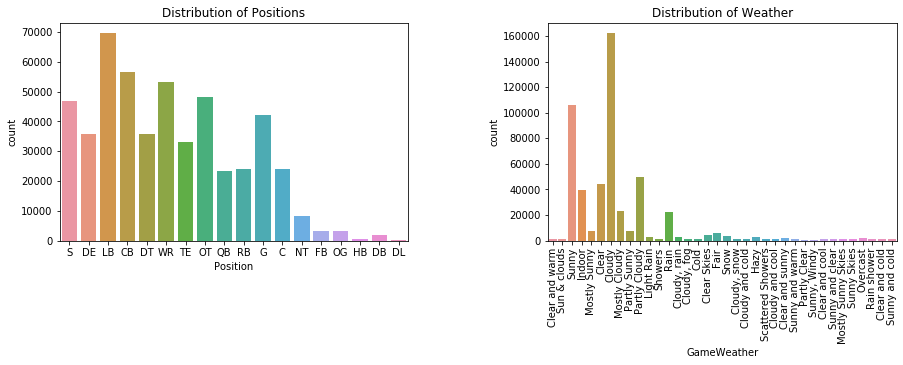

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plt.subplots_adjust(wspace=0.4)
sns.countplot(nfl.Position, ax=axes[0])
sns.countplot(nfl.GameWeather, ax=axes[1])
axes[0].set_title('Distribution of Positions')
axes[1].set_title('Distribution of Weather')
plt.setp(axes[1].get_xticklabels(), rotation=90);

## Data Preprocessing

### Feature Engineering

In [ ]:
nfl['Defenders_vs_Distance'] = nfl['DefendersInTheBox'] / nfl['Distance']